# Link based ranking

**Preliminaries:** If you want to normalize a vector to L1-norm or L2-norm, use:

In [1]:
from __future__ import print_function, division
import numpy as np

pr = np.array([1,2,3])
print("L1-norm of {0} is {1}".format(pr, pr / np.linalg.norm(pr,1)))
print("L2-norm of {0} is {1}".format(pr, pr / np.linalg.norm(pr,2)))

L1-norm of [1 2 3] is [0.16666667 0.33333333 0.5       ]
L2-norm of [1 2 3] is [0.26726124 0.53452248 0.80178373]


## Page Rank (Eigen-vector method)
Consider a tiny Web with three pages A, B and C with no inlinks,
and with initial PageRank = 1. Initially, none of the pages link to
any other pages and none link to them. 
Answer the following questions, and calculate the PageRank for
each question.

1. Link page A to page B.
2. Link all pages to each other.
3. Link page A to both B and C, and link pages B and C to A.
4. Use the previous links and add a link from page C to page B.

**Hints:**
We are using the theoretical PageRank computation (without source of rank). See slide "Transition Matrix for Random Walker" in the lecture note. Columns of link matrix are from-vertex, rows of link matrix are to-vertex. We take the eigenvector with the largest eigenvalue.
We only care about final ranking of the probability vector. You can choose the normalization (or not) of your choice).

In [2]:
def create_Rmatrix(L):
    X = np.sum(L,axis=0)
    n_nodes = L.shape[0]
    R = np.zeros((n_nodes, n_nodes))
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            R[i,j] = L[i,j] / X[0,j] if X[0,j] != 0 else 0
            
    return R

In [3]:
# Implement your code here
def pagerank_eigen(L):
#   Construct transition probability matrix from L
    R = create_Rmatrix(L)
#     Compute eigen-vectors and eigen-values of R
    eigenvalues, eigenvectors = np.linalg.eig(R)
#     Take the eigen-vector with maximum eigven-value
    p = eigenvectors[:, np.argmax(np.absolute(eigenvalues))]
    return (R,p)

In [4]:
# Test with the question, e.g.
L = np.matrix([
    [0,1,1], 
    [1,0,1], 
    [1,1,0]
])
R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

L=[[0 1 1]
 [1 0 1]
 [1 1 0]]
R=[[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
p=[0.57735027 0.57735027 0.57735027]


## Page Rank (Iterative method)

The eigen-vector method has some numerical issues (when computing eigen-vector) and not scalable with large datasets.

We will apply the iterative method in the slide "Practical Computation of PageRank" of the lecture.

Dataset for practice: https://snap.stanford.edu/data/ca-GrQc.html. It is available within the same folder of this github.

In [5]:
def pagerank_iterative(L):
    R = L * (1 / np.sum(L,axis=0))
    N = L.shape[0]
    e = np.ones(shape=(N,1))
    q = 0.9

    p = e
    delta = 1
    epsilon = 0.001
    i = 0
    while delta > epsilon:
        p_prev = p
        p = (q * R) @ p_prev 
        p = p + e * (1 - q) / N
        delta = np.linalg.norm(p - p_prev,1)
        i += 1

    print("Converged after {0} iterations. Ranking vector: p={1}".format(i, p[:,0]))
    return R,p

### Test with the dataset


In [6]:
n_nodes = 0
nodes_idx = dict() #Since the nodeIDs are not from 0 to N we need to build an index of nodes
nodes = [] #We also want to store nodeIDs to return the result of ranking vector

# Read the nodes
with open("ca-GrQc.txt") as f:
    for line in f:
        if '#' not in line:
            source = int(line.split()[0])
            target = int(line.split()[1])
            if source not in nodes_idx.keys():
                nodes_idx[source] = n_nodes
                nodes.append(source)
                n_nodes += 1
            if target not in nodes_idx.keys():
                nodes_idx[target] = n_nodes
                nodes.append(target)
                n_nodes += 1
print(n_nodes)
print(nodes[:3])

5242
[3466, 937, 5233]


In [7]:
L = np.zeros((n_nodes, n_nodes))
# Read the edges
with open("ca-GrQc.txt") as f:
    for line in f:
        if "#" not in line:
            source = int(line.split()[0])
            target = int(line.split()[1])
            L[nodes_idx[target], nodes_idx[source]] = 1 #Columns of link matrix are from-vertices
print(L)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [8]:
# Run PageRank
R, p = pagerank_iterative(L)
print("Ranking vector: p={0}".format(p[:,0]))

Converged after 128 iterations. Ranking vector: p=[2.91315639e-04 1.88382754e-04 8.39741651e-05 ... 1.92156702e-04
 1.92156702e-04 1.92156702e-04]
Ranking vector: p=[2.91315639e-04 1.88382754e-04 8.39741651e-05 ... 1.92156702e-04
 1.92156702e-04 1.92156702e-04]


## Ranking Methodology (Hard)

1. Give a directed graph, as small as possible, satisfying all the properties mentioned below:

    1. There exists a path from node i to node j for all nodes i,j in the directed
graph. Recall, with this property the jump to an arbitrary node in PageRank
is not required, so that you can set q = 1 (refer lecture slides).

    2. HITS authority ranking and PageRank ranking of the graph nodes are different.

2. Give intuition/methodology on how you constructed such a directed graph with
the properties described in (a).

3. Are there specific graph structures with arbitrarily large instances where PageRank
ranking and HITS authority ranking are the same?

## Question 4 - Hub and Authority

### a)

Let the adjacency matrix for a graph of four vertices ($n_1$ to $n_4$) be
as follows:

$
A =
  \begin{bmatrix}
	0 & 1 & 1 & 1  \\
	0 & 0 & 1 & 1 \\
	1 & 0 & 0 & 1 \\
	0 & 0 & 0 & 1 \\
  \end{bmatrix}
$

Calculate the authority and hub scores for this graph using the
HITS algorithm with k = 6, and identify the best authority and
hub nodes.

### b)
Apply the HITS algorithm to the dataset: https://snap.stanford.edu/data/ca-GrQc.html

**Hint:** We follow the slide "HITS algorithm" in the lecture. **Denote $x$ as authority vector and $y$ as hub vector**. You can use matrix multiplication for the update steps in the slide "Convergence of HITS". Note that rows of adjacency matrix is from-vertex and columns of adjacency matrix is to-vertex.

In [9]:
# You can implement your code following this template.
def hits_iterative(A, k=10):
    N = A.shape[0]

    x0, y0 = 1 / (N*N) * np.ones(N), 1 / (N*N) * np.ones(N) 

    xprev, yprev = x0, y0
    
    # For advanced exercise: define a convergence condition instead of k iterations
    for l in range(0,k):
        y = A @ xprev
        x = A.T @ y 
        x = x / np.linalg.norm(x,2)
        y = y / np.linalg.norm(y,2)
        xprev = x
        yprev = y
        
    return xprev, yprev

In [10]:
A=np.array([
    [0, 1, 1, 1], 
    [0, 0, 1, 1], 
    [1, 0, 0, 1],
    [0, 0, 0, 1],
])

x, y = hits_iterative(A, 100)
print("Result using iterative method:\n Authoriy vector x={0}\n Hub vector y={1}".format(x, y))

Result using iterative method:
 Authoriy vector x=[0.16845787 0.27257056 0.49801119 0.80579904]
 Hub vector y=[0.65549599 0.54215478 0.4051188  0.33507008]


# Introducing Word Embeddings

In this exercise, we would train word embeddings using a state-of-the-art embeddings library fastText. The first step of the exercise is to install the fasttext library. Proceed with the following steps:

## FastText installation

> pip install fasttext

If you are having problems, try this command:
> sudo apt-get install g++

## Generate Embeddings

In [11]:
import fasttext
import numpy as np

In [12]:
model = fasttext.train_unsupervised('epfldocs.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

## Use Pretrained Embeddings
If you are unable to install fasttext, you can use the preembeddings we provide.

In [ ]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')




## Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') 
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.003s...
[t-SNE] Computed neighbors for 432 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.072915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.991791
[t-SNE] KL divergence after 1000 iterations: 0.116745


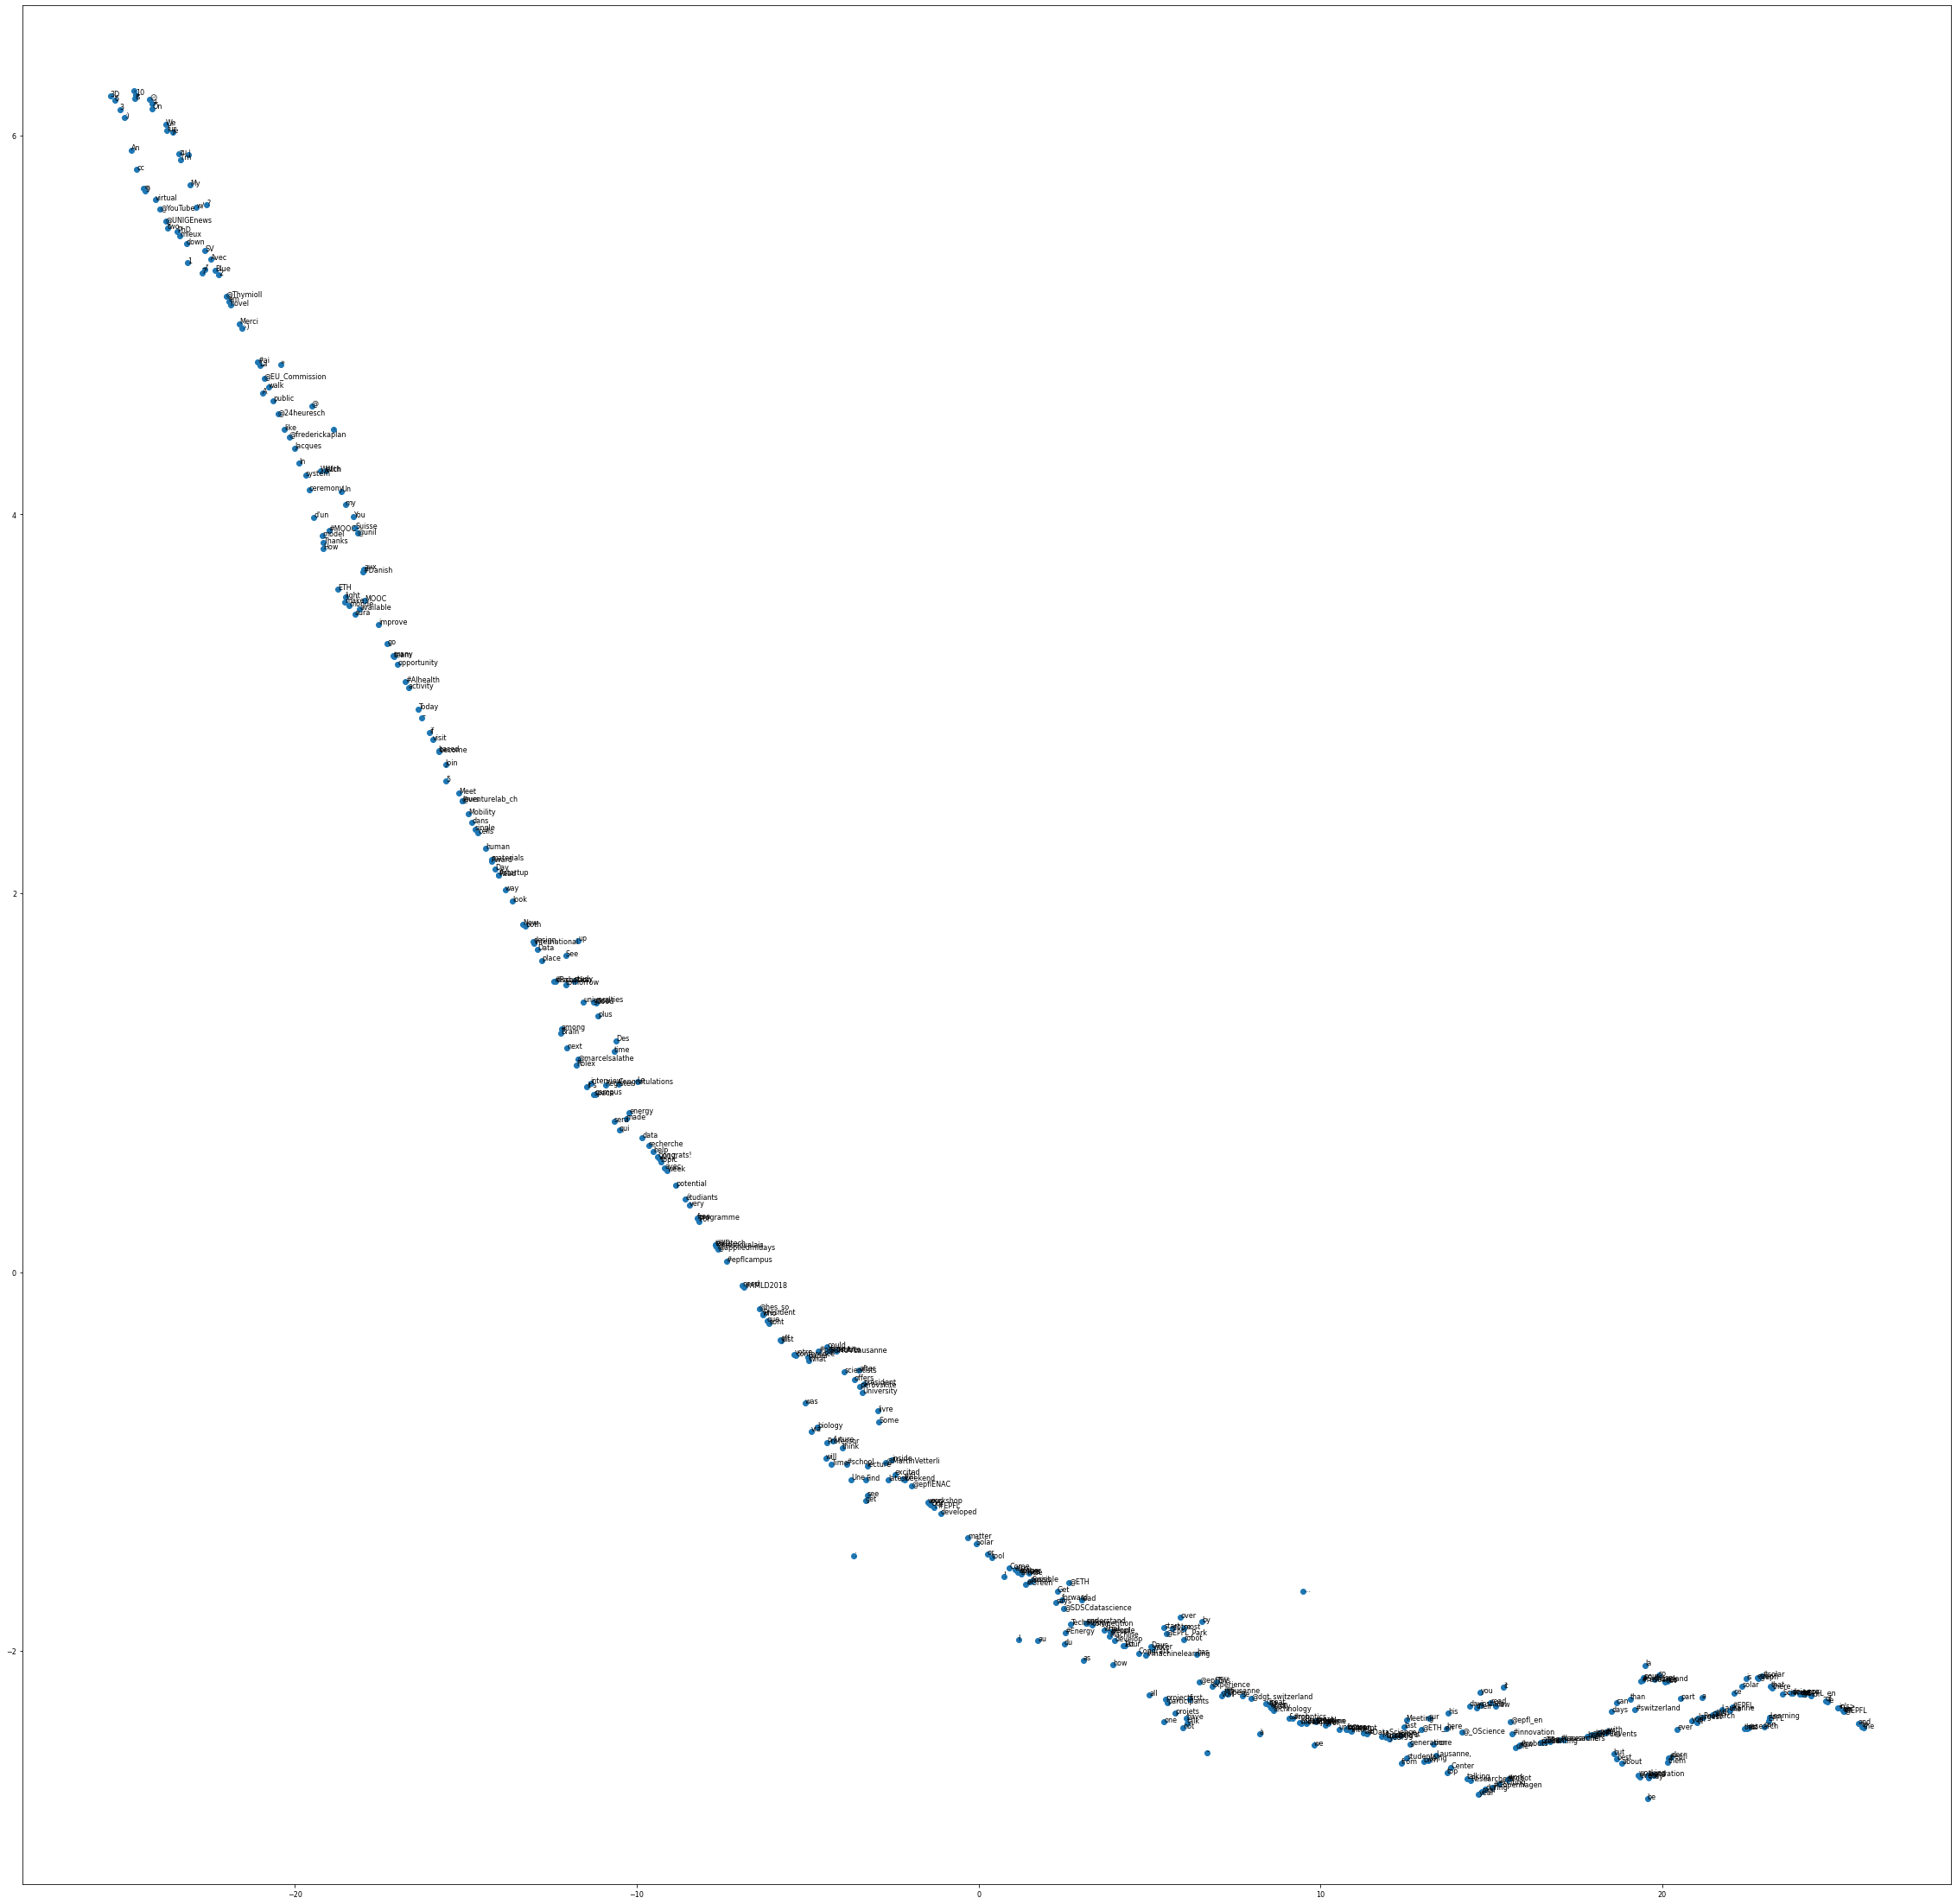

In [14]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Question

Observe the plot of word embeddings. Do you observe any patterns?



## Question

Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings.

Find the top 5 terms that are most similar to 'la', 'EPFL', '#robot', 'this', 

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=5):
    term_embeddings_dict = {}
    for i,term in enumerate(vocabulary):
        term_embeddings_dict[term] = word_embeddings[i]
        
    term_embedding = term_embeddings_dict[input_term]
    similarities = sorted([(x, cosine_similarity(term_embedding.reshape(1, -1), term_embeddings_dict[x].reshape(1, -1))) for x in vocabulary], key = lambda x: x[1], reverse=True)
    return similarities[:num_terms]

find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)

[('EPFL', array([[0.9999999]], dtype=float32)),
 ('@EPFL_en', array([[0.99999523]], dtype=float32)),
 ('@dgt_switzerland', array([[0.9999948]], dtype=float32)),
 ('Researchers', array([[0.99999475]], dtype=float32)),
 ('researchers', array([[0.99999475]], dtype=float32))]

## Question [Optional]
​
Observe the word embeddings that are visualized in this link http://www.anthonygarvan.com/wordgalaxy/ . Can you make some interesting observations? 

# Basic Search Engine Using Word Embeddings



In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.



In [21]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 

## Question

Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [28]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.max(vlist, axis=0)
    elif aggfunc == 'min':
        return np.min(vlist, axis=0)
    elif aggfunc == 'mean':
        return np.mean(vlist, axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
# TODO
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc)

In [29]:
aggregated_doc_vectors

{'max': array([[-0.08801146,  0.73216999, -0.02347608, ...,  0.3896488 ,
         -0.16920607, -0.14257069],
        [-0.08942581,  0.5110271 , -0.02214939, ...,  0.27228761,
         -0.17391124, -0.14728022],
        [-0.07716278,  0.52189022, -0.02005836, ...,  0.27738157,
         -0.14761484, -0.12590885],
        ...,
        [-0.09128806,  0.73216999, -0.02437968, ...,  0.3896488 ,
         -0.18011236, -0.15254481],
        [-0.1187417 ,  0.58852232, -0.02772788, ...,  0.30900657,
         -0.23370492, -0.20262535],
        [-0.1023526 ,  0.58852232, -0.02595995, ...,  0.30900657,
         -0.20079368, -0.17172652]]),
 'min': array([[-0.2105186 ,  0.30115139, -0.05680897, ...,  0.16020566,
         -0.4116106 , -0.34553427],
        [-0.14586127,  0.30623287, -0.04028698, ...,  0.16336107,
         -0.28917345, -0.24695957],
        [-0.15035991,  0.2623966 , -0.04091916, ...,  0.13985908,
         -0.29411536, -0.24667375],
        ...,
        [-0.2105186 ,  0.3187674 , -0.05

## Question

Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector. Are they seem to relevant?

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    query_emb = [vector_dict[token] for token in fasttext.tokenize(query) if token in vector_dict]
    if not query_emb:
        raise ValueError()
        
    return aggregate_vector_list(query_emb, aggfunc)
    # TODO
    # Raise an error message for the case when there is no words in the query that is included in the vocabulary
    # This should return a vector of shape (1, word_embeddings.shape[1])
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    # Calculate the similarity with each document vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    query_v = query_vector.reshape(1, -1)
    sim = cosine_similarity(query_v, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with the query vector and return topk indexes
    indexes = np.argsort(sim, axis=-1, order=None) # This is sorted in ascending order
    indexes = indexes[0][::-1]
    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [33]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Today is lab day: great honor to welcome @NobelPrize winner Jacques Dubochet and talk about #serendipity! @unil @EPFL @EPFL_en @EPFLevents https://t.co/wiRwfHoU4I
So excited to see @EPFL among the inaugural partners @GIX_edu (Global Innovation Exchange) w/ @UW &amp; @Tsinghua_Uni!  https://t.co/C9C96WEe6b
MOOC on household level water treatment methods &amp; successful implementation strategies and assessing impact thereof. Part of “Sanitation, Water &amp; Solid Waste for Development” MOOC series. Free and running continuously. https://t.co/2ibzrsPR4b @EawagResearch @EPFL https://t.co/bH4l44ZsMN
Time to take down the last Christmas decorations and get started on our new projects for 2018 🎉 #rrl #epfl #robot #newyear #modular #reconfigurable #soft #origami #2018 https://t.co/OfHQ1oxs4n
Open call for Science and Technology #womenentrepreneurs! Applications for the 2018 Musy Award @EPFL VP Innovation are open. Apply to get 

## Question

Compare the results with the vector space retrieval.

In [34]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = cosine_similarity(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [35]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Today is lab day: great honor to welcome @NobelPrize winner Jacques Dubochet and talk about #serendipity! @unil @EPFL @EPFL_en @EPFLevents https://t.co/wiRwfHoU4I
So excited to see @EPFL among the inaugural partners @GIX_edu (Global Innovation Exchange) w/ @UW &amp; @Tsinghua_Uni!  https://t.co/C9C96WEe6b
MOOC on household level water treatment methods &amp; successful implementation strategies and assessing impact thereof. Part of “Sanitation, Water &amp; Solid Waste for Development” MOOC series. Free and running continuously. https://t.co/2ibzrsPR4b @EawagResearch @EPFL https://t.co/bH4l44ZsMN
Time to take down the last Christmas decorations and get started on our new projects for 2018 🎉 #rrl #epfl #robot #newyear #modular #reconfigurable #soft #origami #2018 https://t.co/OfHQ1oxs4n
Open call for Science and Technology #womenentrepreneurs! Applications for the 2018 Musy Award @EPFL VP Innovation are open. Apply to get 

## Question
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.